Part 1: EDA

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

Read in file.

In [2]:
login = pd.read_json(r'C:\Users\agrae\Documents\AAA_Work\Coding\Springboard\HW\002_Machine_learning_case_studies\Take-Home_Challenge\logins.json')
login.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [3]:
login.isnull().sum()

login_time    0
dtype: int64

In [4]:
login.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


It's looking good! There are no null values and everything looks normal. Let's now count up how many inputs we have per 15 minute period.

In [5]:
login['num_login'] = 1
login.set_index('login_time', inplace=True)
login.head()

,num_login
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [6]:
df = login.resample('15T').sum()
df.head(), df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Freq: 15T
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   num_login  9788 non-null   int64
dtypes: int64(1)
memory usage: 152.9 KB


(                     num_login
 login_time                    
 1970-01-01 20:00:00          2
 1970-01-01 20:15:00          6
 1970-01-01 20:30:00          9
 1970-01-01 20:45:00          7
 1970-01-01 21:00:00          1,
 None)

Perfect! Now let's plot it out and look at the seasonal decomposition.

<AxesSubplot:xlabel='login_time'>

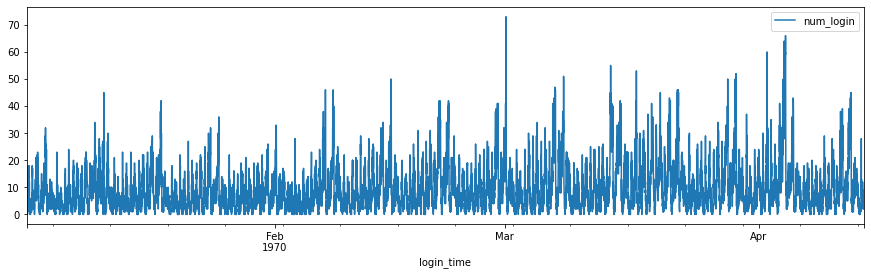

In [7]:
fig, ax = plt.subplots(1, figsize=(15, 4))
df.plot(ax=ax)

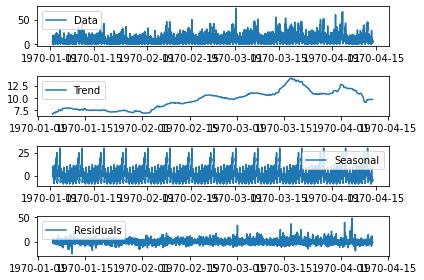

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(df, period=672)

trend = decomp.trend
seasonal = decomp.seasonal
resid = decomp.resid

plt.subplot(411)
plt.plot(df, label = 'Data')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonal')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(resid, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

In [9]:
df_week1 = df.iloc[:672,:]
df_week2 = df.iloc[672:1344, :]
df_week3 = df.iloc[1344:2016, :]

df_week1.head()

,num_login
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


<AxesSubplot:xlabel='login_time'>

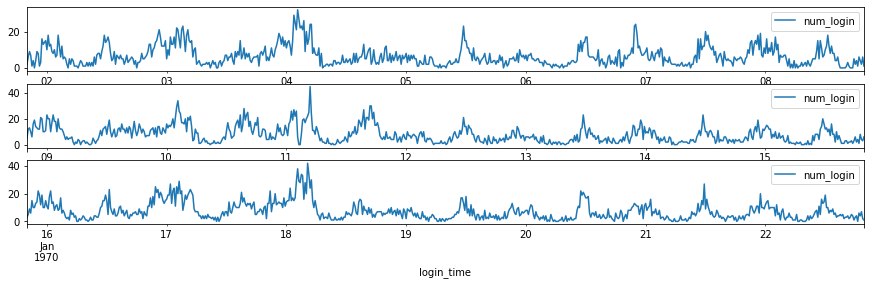

In [10]:
fig, ax = plt.subplots(3, 1, figsize=(15, 4))
df_week1.plot(ax=ax[0])
df_week2.plot(ax=ax[1])
df_week3.plot(ax=ax[2])

We can see large spikes during the mid days and late nights centered around 12 AM and 12 PM but the largest spikes in activity are during Friday nights and Saturday nights (I googled what days of the week these days in January were in 1970).

Part 2: Experiment and Metric Design

Background: The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.

Q1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
A1. This really depends on pre-existing partnership between driver partners and Ultimate managers. That being said, I would say a 25% increase in driver partner activity in both cities would be a measurable and significant increase in activity and could be considered a success should that value be attained.

Q2.Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment.
b. what statistical test(s) you will conduct to verify the significance of the observation.
c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.
A2. Considering we are unsure what the budget looks like for this experiment or the degree of control the managers have on the drivers, no truly good experiment can be proposed. Those things aside, one could have the drivers register the number of drivers in each city. Then, each driver could show ID when crossing the toll booth in order to ensure free passage. I would actually do things slightly differently in that I would, for the first X amount of time (Depends on how much time the department is willing to devote to this experiment), offer a very slight discount in crossing for driver partners to gauge the "baseline" number of driver partners crossing the toll. Then I would offer the crossing for free and check the difference in driving partners crossing. This would be an incredibly cheap and easy way to do the experiment (if not the absolute most accurate).

Part 3: Predictive Modeling

Let's import the new data and start cleaning it up a little.

In [11]:
df = pd.read_json(r'C:\Users\agrae\Documents\AAA_Work\Coding\Springboard\HW\002_Machine_learning_case_studies\Take-Home_Challenge\ultimate_data_challenge.json')
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


<AxesSubplot:xlabel='avg_rating_of_driver', ylabel='Count'>

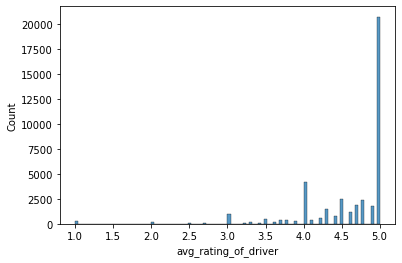

In [13]:
sns.histplot(x='avg_rating_of_driver', data=df)

In [14]:
perc_df = df.groupby('avg_rating_of_driver').size()/41878
perc_df

avg_rating_of_driver
1.0    0.006113
1.5    0.000096
1.6    0.000024
1.7    0.000048
1.8    0.000048
1.9    0.000024
2.0    0.004991
2.1    0.000143
2.2    0.000024
2.3    0.000525
2.4    0.000072
2.5    0.002245
2.6    0.000287
2.7    0.001122
2.8    0.000669
2.9    0.000310
3.0    0.023951
3.1    0.000931
3.2    0.001266
3.3    0.004800
3.4    0.002579
3.5    0.011653
3.6    0.004107
3.7    0.008692
3.8    0.010220
3.9    0.006089
4.0    0.100124
4.1    0.009504
4.2    0.014351
4.3    0.035508
4.4    0.019796
4.5    0.059649
4.6    0.027294
4.7    0.046444
4.8    0.058026
4.9    0.042290
5.0    0.495988
dtype: float64

It looks like about 10% of the reviews are 4 star and about 50% of the reviews are 5 star reviews. Let's fill with those two largest values

In [15]:
df_5 = df.iloc[:37500,:]
df_4 = df.iloc[37500:,:]
df_5['avg_rating_of_driver'].fillna(5, inplace=True)
df_4['avg_rating_of_driver'].fillna(4, inplace=True)
df= df_5.append(df_4)

C:\Users\agrae\anaconda3\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    50000 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


<AxesSubplot:xlabel='avg_rating_of_driver', ylabel='Count'>

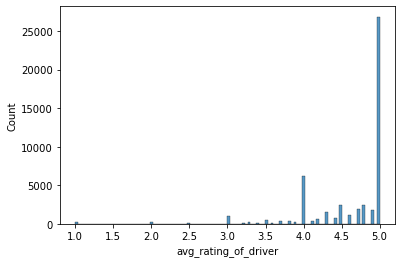

In [17]:
sns.histplot(x='avg_rating_of_driver', data=df)

In [18]:
df.groupby('avg_rating_of_driver').size()/41878

avg_rating_of_driver
1.0    0.006113
1.5    0.000096
1.6    0.000024
1.7    0.000048
1.8    0.000048
1.9    0.000024
2.0    0.004991
2.1    0.000143
2.2    0.000024
2.3    0.000525
2.4    0.000072
2.5    0.002245
2.6    0.000287
2.7    0.001122
2.8    0.000669
2.9    0.000310
3.0    0.023951
3.1    0.000931
3.2    0.001266
3.3    0.004800
3.4    0.002579
3.5    0.011653
3.6    0.004107
3.7    0.008692
3.8    0.010220
3.9    0.006089
4.0    0.148503
4.1    0.009504
4.2    0.014351
4.3    0.035508
4.4    0.019796
4.5    0.059649
4.6    0.027294
4.7    0.046444
4.8    0.058026
4.9    0.042290
5.0    0.641554
dtype: float64

Now there are about 15% of the 4 star reviews and about 65% of the 5 star reviews. Not great but okay.

<AxesSubplot:>

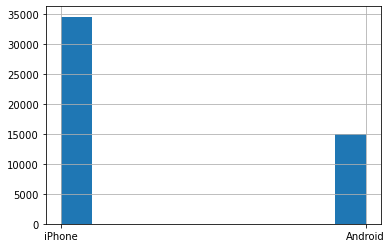

In [19]:
df.phone.hist()

Looks like a pretty easy split between iPhone and Android. We'll fill with the current ratio because there are so few NA's.

In [20]:
df_iphone = df.iloc[:35000,:]
df_android = df.iloc[35000:,:]
df_iphone['phone'].fillna('iPhone', inplace=True)
df_android['phone'].fillna('Android', inplace=True)
df= df_iphone.append(df_android)

C:\Users\agrae\anaconda3\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    50000 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   50000 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


<AxesSubplot:xlabel='avg_rating_by_driver', ylabel='Count'>

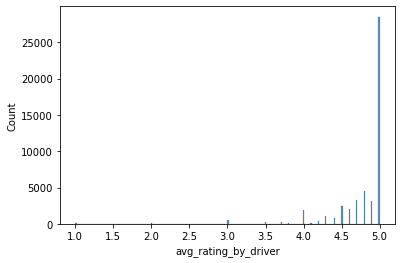

In [22]:
sns.histplot(x='avg_rating_by_driver', data=df)

There's only about 200 missing values here and 5 star ratings are overwhelming. We'll just fill with 5.

In [23]:
df['avg_rating_by_driver'].fillna(5, inplace=True)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    50000 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   50000 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    50000 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


We've dealt with NA's. Let's now see if all the data makes sense with the DESCRIBE function.

In [25]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2.278200,4.625762,1.074764,8.849536,60.926084,5.796827,4.779050
std,3.792684,0.593828,0.222336,19.958811,37.081503,5.707357,0.445974
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,5.000000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


Everything looks good! All of the data above seems to make sense.

Let's build a model to predict how many users will stay active longer than 5 months. Let's start by making a dummy variable for our y. To do that we'll need to make our sign up dates and our last trip dates datetime objects.

In [26]:
df['signup_date'] = pd.to_datetime(df.signup_date)
df['last_trip_date'] = pd.to_datetime(df.last_trip_date)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [28]:
df["length_of_work"] = df.last_trip_date - df.signup_date

In [29]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,length_of_work
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,143 days
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,96 days
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,1 days
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,170 days
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,47 days


If anyone has above 150 days then we will label them a "committed driver" with a 1.

In [30]:
how_long = df.length_of_work > '150 days'

In [31]:
df['committed_driver'] = how_long.astype(int)

In [32]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,length_of_work,committed_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,143 days,0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,96 days,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,1 days,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,170 days,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,47 days,0


Let's remove "length of work" and turn out x variables into dummies as well.

In [33]:
df = df.join(pd.get_dummies(df.phone, drop_first=True))

In [34]:
df.ultimate_black_user = df.ultimate_black_user.astype(int)

In [35]:
df['city'] = df.city.replace({"King's Landing":0, 'Astapor':1, 'Winterfell':2}, regex=True)

In [36]:
df.drop('phone', inplace=True, axis=1)

In [37]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,length_of_work,committed_driver,iPhone
0,0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,1,46.2,3.67,5.0,143 days,0,1
1,1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,0,50.0,8.26,5.0,96 days,0,0
2,1,3,2014-01-06,4.3,1.00,2014-01-07,0.0,0,100.0,0.77,5.0,1 days,0,1
3,0,9,2014-01-10,4.6,1.14,2014-06-29,20.0,1,80.0,2.36,4.9,170 days,1,1
4,2,14,2014-01-27,4.4,1.19,2014-03-15,11.8,0,82.4,3.13,4.9,47 days,0,0


In [38]:
df.city.unique()

array([0, 1, 2], dtype=int64)

Everything looks good. Let's make our model. We'll use the logistic regression model. Let's get our x and our y.

In [39]:
x = df.drop(['signup_date', 'last_trip_date', 'length_of_work', 'committed_driver'], axis=1)

In [40]:
y = df[['committed_driver']]

In [41]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.2)

In [42]:
model = LogisticRegression()
model.fit(X_train, y_train)

C:\Users\agrae\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\agrae\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [43]:
model.score(X_test, y_test)

0.7661

This model looks really good! It has predicted with above 75% accuracy who will remain using this service after 5 months. This will be useful to our client to know who they should be targeting their advertisments to and who they will be able to rely on using their service!